# DeepTesla for MLND
### 2018.9.1 by Neo

# 0 Load Env


In [1]:
# Dependence

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import cv2
%matplotlib inline

np.random.seed(42)

# local file
import preparedata
import params


D:\3MachineLearning\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1 Explore Data

See the file "Explore_Data .ipynb"

# 2 Prepare Data

## 2.1 Train Data

In [ ]:
#  YUV without flip
YUV_imgs_data, YUV_wheels_data = preparedata.load_data('train', 'YUV', flip=False)
plt.imshow(YUV_imgs_data[6])
YUV_imgs_data.shape, YUV_wheels_data.shape

## 2.2 Test Data 

In [ ]:
# Test data without flip
imgs_test, wheels_test = preparedata.load_data('test', 'YUV')
plt.imshow(imgs_test[1])
imgs_test.shape, wheels_test.shape

## 2.3 Save Checkpoint

In [ ]:
# Save train data into a pickle file.
import pickle

pickle.dump(YUV_imgs_data, open('.\inbox\data_imgs_train.p', 'wb'))
pickle.dump(YUV_wheels_data, open('.\inbox\data_wheels_train.p', 'wb'))


In [ ]:
# Save test data into a pickle file.
pickle.dump(imgs_test, open('.\inbox\data_imgs_test.p', 'wb'))
pickle.dump(wheels_test, open('.\inbox\data_wheels_test.p', 'wb'))

## 2.4 Load Checkpoint

In [2]:
# Load data back from the pickle file.
import pickle
imgs_data = pickle.load(open('.\inbox\data_imgs_train.p', 'rb'))
wheels_data = pickle.load(open('.\inbox\data_wheels_train.p', 'rb'))

imgs_test = pickle.load(open('.\inbox\data_imgs_test.p', 'rb'))
wheels_test = pickle.load(open('.\inbox\data_wheels_test.p', 'rb'))

In [3]:
# Check the data dimension
print(imgs_data.shape, wheels_data.shape)
print(imgs_test.shape, wheels_test.shape)

(24300, 66, 200, 3) (24300, 1)
(2700, 66, 200, 3) (2700, 1)


## 2.5 Split Data 

In [4]:
def split_data_set(x, y, test_size, shuffle=False):
    '''Split into train and valid sets with shuffle or order'''
    if shuffle:
        from sklearn.model_selection import train_test_split
        X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=test_size, random_state=42)
    else:
        split_point = int(len(wheels_data) * (1-test_size))
        X_train, X_val = x[:split_point], x[split_point:]
        y_train, y_val = y[:split_point], y[split_point:]
    return X_train, X_val, y_train, y_val

In [5]:
# Split data into train and valid sets
X_train, X_val, y_train, y_val = split_data_set(imgs_data, wheels_data, test_size=0.2, shuffle=True)

print(X_train.shape[0], 'train samples, ', X_val.shape[0], 'Valid samples')
print('X_train shape:', X_train.shape, '\nX_val shape:',X_val.shape)
print('y_train shape:',y_train.shape, '\ny_val shape:',y_val.shape)

19440 train samples,  4860 Valid samples
X_train shape: (19440, 66, 200, 3) 
X_val shape: (4860, 66, 200, 3)
y_train shape: (19440, 1) 
y_val shape: (4860, 1)


# 3 Build Model

## Model1 - VGG16 + Transfer learning

In [9]:
# VGG16 with ordered data 

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam


# VGG16 model
def raw_vgg_model(img_height, img_width, img_channels):
    # create the base pre-trained model

    base_model = VGG16(input_shape=(img_height,img_width,img_channels),weights='imagenet',include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = Flatten()(x)
    # add a fully-connected layer
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    #and a logistic layer -- let's say we have 1 classes
    predictions = Dense(1, activation='relu')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # # the first 8 layers and unfreeze the rest:
    for layer in model.layers[:8]:
       layer.trainable = False
    for layer in model.layers[8:]:
       layer.trainable = True
    
    # we need to recompile the model for these modifications to take effect
    model.summary()
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model




In [10]:
# # load model if exists
# raw_vgg_model = load_model('.\\inbox\\raw_vgg16_model.h5')


# Train the  model with ordered data 
raw_vgg_model = raw_vgg_model(66,200, 3)
time_start = time.time()
# Fit the model
raw_vgg_history = raw_vgg_model.fit(imgs_data, wheels_data,
                              epochs=10, 
                              batch_size=32,
                              validation_split=0.2)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= raw_vgg_model.evaluate(imgs_test, wheels_test, batch_size=64)#512跑不动
print('Test loss is:{}'.format(test_loss))

KeyboardInterrupt: 

dict_keys(['val_loss', 'loss'])


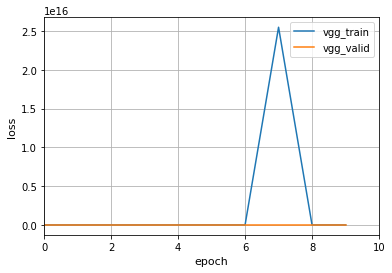

In [12]:
## Visualization
# list all data in history
print(raw_vgg_history.history.keys())
# summarize history for loss
plt.plot(raw_vgg_history.history['loss'])
plt.plot(raw_vgg_history.history['val_loss'])

# plt.title('model loss')
plt.ylabel('loss', fontsize=11)
plt.xlabel('epoch', fontsize=11)
plt.legend(['vgg_train', 'vgg_valid'], loc='best')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 2))
plt.grid()
plt.show()

In [13]:
#save model
raw_vgg_model.save('.\\inbox\\raw_vgg16_model.h5')

## Model2 - Raw NVIDIA End to End Model

In [6]:
import tensorflow as tf 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D,Convolution2D
from keras import losses, regularizers
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [11]:
def nvidia_model(img_height, img_width, img_channels):
    input_shape = (img_height, img_width, img_channels)
    model = Sequential()
    model.add(Lambda(lambda x:x/255.0, input_shape=input_shape))
#     model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu', padding='same'))
#     model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu', padding='same'))
#     model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu', padding='same'))
#     model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='same'))
#     model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='same'))
    ###
    model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu'))
    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu'))
    ###
    
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
#     model.add(Dense(1, activation='tanh'))
    model.add(Dense(1))
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss="mse")
    model.summary()
    return model

In [12]:
# Train the End to End model with ordered data 
withoutpadding_nvidia_model = nvidia_model(66, 200, 3)
time_start = time.time()
# Fit the model
withoutpadding_nvidia_history = withoutpadding_nvidia_model.fit(imgs_data, wheels_data,
                              epochs=20, 
                              batch_size=512,
                              validation_split=0.2)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= withoutpadding_nvidia_model.evaluate(imgs_test, wheels_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
__________

In [26]:
# Train the End to End model with ordered data 
raw_nvidia_model = nvidia_model(66, 200, 3)
time_start = time.time()
# Fit the model
raw_nvidia_history = raw_nvidia_model.fit(imgs_data, wheels_data,
                              epochs=20, 
                              batch_size=512,
                              validation_split=0.2)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= raw_nvidia_model.evaluate(imgs_test, wheels_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 100, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 50, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 25, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 25, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 25, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 14400)             0         
__________

dict_keys(['val_loss', 'loss'])


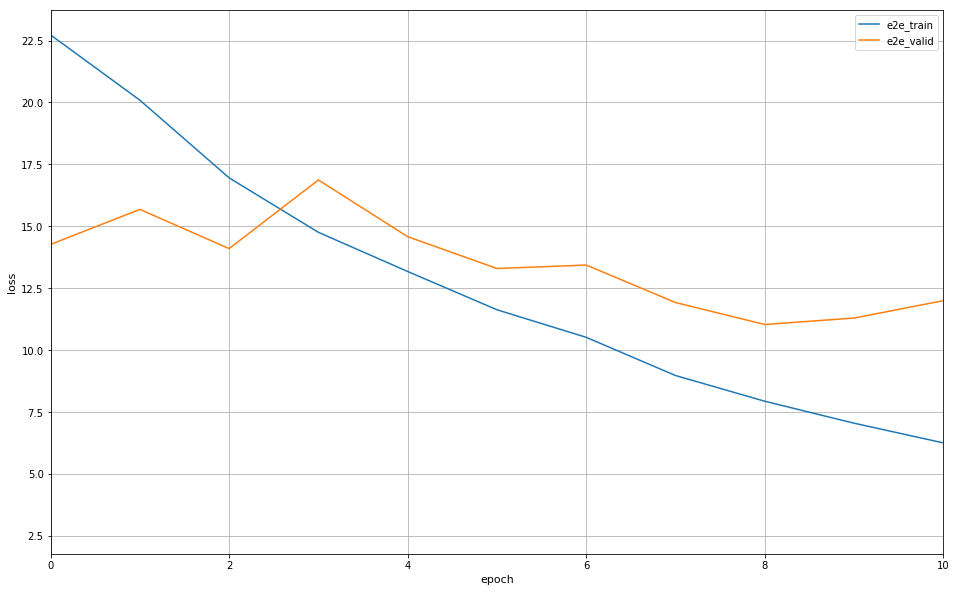

In [27]:
# list all data in history
print(raw_nvidia_history.history.keys())
# summarize history for loss
plt.plot(raw_nvidia_history.history['loss'])
plt.plot(raw_nvidia_history.history['val_loss'])

# plt.title('model loss')
plt.ylabel('loss', fontsize=11)
plt.xlabel('epoch', fontsize=11)
plt.legend(['e2e_train', 'e2e_valid'], loc='best')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 2))
plt.grid()
plt.show()

In [28]:
#save model
raw_nvidia_model.save('.\\inbox\\raw_nividia_model.h5')

# Model3 -  End to End + Maxpool

In [15]:
# Add Maxpooling 
# padding = same

def maxpool_model(img_height, img_width, img_channels):
    
    image_shape = (img_height, img_width, img_channels)

    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0, input_shape=image_shape))
    

    model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(1))
    
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [16]:
# Train the model
maxpool_model = maxpool_model(66, 200, 3)
time_start = time.time()
# Fit the model
maxpool_history = maxpool_model.fit(imgs_data, wheels_data,
                              epochs=20, 
                              batch_size=512,
                              validation_split=0.2) 

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= maxpool_model.evaluate(imgs_test, wheels_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 33, 100, 24)       1824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 50, 24)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 25, 36)         21636     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 13, 36)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 7, 48)          43248     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 4, 48)          0         
__________

dict_keys(['val_loss', 'loss'])


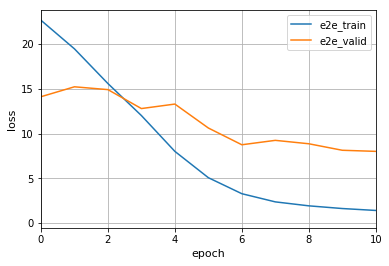

In [17]:
# list all data in history
print(maxpool_history.history.keys())
# summarize history for loss
plt.plot(maxpool_history.history['loss'])
plt.plot(maxpool_history.history['val_loss'])

# plt.title('model loss')
plt.ylabel('loss', fontsize=11)
plt.xlabel('epoch', fontsize=11)
plt.legend(['e2e_train', 'e2e_valid'], loc='best')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 2))
plt.grid()
plt.show()

In [18]:
#save model
maxpool_model.save('.\\inbox\\maxpool_model.h5')

# Model4 -  End to End + Maxpool + Dropout

In [19]:
def dropout_model(img_height, img_width, img_channels):
    
    image_shape = (img_height, img_width, img_channels)

    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0, input_shape=image_shape))
    

    model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(1164))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [20]:
# Train the model
dropout_model = dropout_model(66, 200, 3)
time_start = time.time()
# Fit the model
dropout_history = dropout_model.fit(imgs_data, wheels_data,
                              epochs=20, 
                              batch_size=512,
                              validation_split=0.2) 

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= dropout_model.evaluate(imgs_test, wheels_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 33, 100, 24)       1824      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 50, 24)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 9, 25, 36)         21636     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 13, 36)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 7, 48)          43248     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 4, 48)          0         
__________

dict_keys(['val_loss', 'loss'])


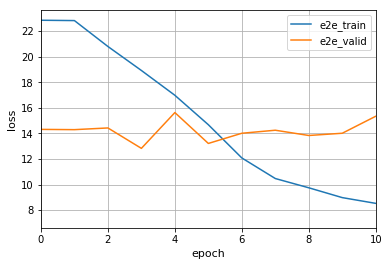

In [21]:
# list all data in history
print(dropout_history.history.keys())
# summarize history for loss
plt.plot(dropout_history.history['loss'])
plt.plot(dropout_history.history['val_loss'])

# plt.title('model loss')
plt.ylabel('loss', fontsize=11)
plt.xlabel('epoch', fontsize=11)
plt.legend(['e2e_train', 'e2e_valid'], loc='best')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 2))
plt.grid()
plt.show()

In [22]:
#save model
dropout_model.save('.\\inbox\\dropout_model.h5')

# Model5 - End to End+Maxpool+Dropout+ELU

In [23]:
def elu_model(img_height, img_width, img_channels):
    
    image_shape = (img_height, img_width, img_channels)

    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0, input_shape=image_shape))
    

    model.add(Conv2D(24, (5,5), strides=(2,2), activation='elu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(36, (5,5), strides=(2,2), activation='elu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(48, (5,5), strides=(2,2), activation='elu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='elu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='elu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(1164))
    model.add(Activation('elu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(100))
    model.add(Activation('elu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(50))
    model.add(Activation('elu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(10))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [24]:
# Train the model
elu_model = elu_model(66, 200, 3)
time_start = time.time()
# Fit the model
elu_history = elu_model.fit(imgs_data, wheels_data,
                              epochs=20, 
                              batch_size=512,
                              validation_split=0.2) 

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= elu_model.evaluate(imgs_test, wheels_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 33, 100, 24)       1824      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 50, 24)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 9, 25, 36)         21636     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 13, 36)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 7, 48)          43248     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 2, 4, 48)          0         
__________

dict_keys(['val_loss', 'loss'])


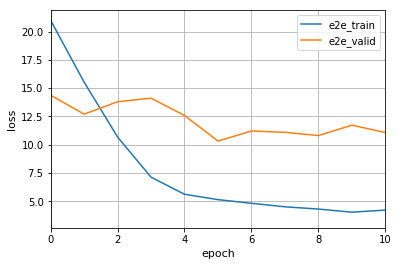

In [25]:
# list all data in history
print(elu_history.history.keys())
# summarize history for loss
plt.plot(elu_history.history['loss'])
plt.plot(elu_history.history['val_loss'])

# plt.title('model loss')
plt.ylabel('loss', fontsize=11)
plt.xlabel('epoch', fontsize=11)
plt.legend(['e2e_train', 'e2e_valid'], loc='best')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 2))
plt.grid()
plt.show()

In [26]:
#save model
elu_model.save('.\\inbox\\elu_model.h5')

# Model6 - E2E+Maxpool+Dropout+ELU+ BN


In [27]:
## add BatchNormalization
def bn_model(img_height, img_width, img_channels):
    
    image_shape = (img_height, img_width, img_channels)

    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0, input_shape=image_shape))
    

    model.add(Conv2D(24, (5,5), strides=(2,2), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(36, (5,5), strides=(2,2), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(48, (5,5), strides=(2,2), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(1164))
    model.add(Activation('elu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(100))
    model.add(Activation('elu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(50))
    model.add(Activation('elu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(10))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [28]:
# Train the model
bn_model = bn_model(66, 200, 3)
time_start = time.time()
# Fit the model
bn_history = bn_model.fit(imgs_data, wheels_data,
                              epochs=20, 
                              batch_size=512,
                              validation_split=0.2) 

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= bn_model.evaluate(imgs_test, wheels_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 33, 100, 24)       1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 100, 24)       96        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 17, 50, 24)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 9, 25, 36)         21636     
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 25, 36)         144       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 5, 13, 36)         0         
__________

dict_keys(['val_loss', 'loss'])


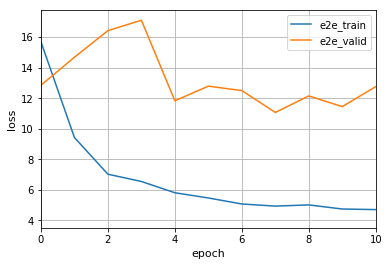

In [29]:
# list all data in history
print(bn_history.history.keys())
# summarize history for loss
plt.plot(bn_history.history['loss'])
plt.plot(bn_history.history['val_loss'])

# plt.title('model loss')
plt.ylabel('loss', fontsize=11)
plt.xlabel('epoch', fontsize=11)
plt.legend(['e2e_train', 'e2e_valid'], loc='best')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 2))
plt.grid()
plt.show()

In [30]:
#save model
bn_model.save('.\\inbox\\bn_model.h5')

# Model7 - Kernel initializer

In [31]:

## E2E+Maxpool+Dropout+ELU+ BatchNormalization+ kernel_initializer

def ki_model(img_height, img_width, img_channels):
    
    image_shape = (img_height, img_width, img_channels)

    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0, input_shape=image_shape))
    
    
    
   
    

    model.add(Conv2D(24, (5,5), strides=(2,2), activation='elu',kernel_initializer='he_normal',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(36, (5,5), strides=(2,2), activation='elu',kernel_initializer='he_normal',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(48, (5,5), strides=(2,2), activation='elu',kernel_initializer='he_normal',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='elu',kernel_initializer='he_normal',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='elu',kernel_initializer='he_normal',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))
    


    
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(1164,kernel_initializer='he_normal'))
    model.add(Activation('elu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(100,kernel_initializer='he_normal'))
    model.add(Activation('elu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(50,kernel_initializer='he_normal'))
    model.add(Activation('elu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(10,kernel_initializer='he_normal'))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [32]:
# Train the model
ki_model = ki_model(66, 200, 3)
time_start = time.time()

# Fit the model
ki_history = ki_model.fit(imgs_data, wheels_data,
                              epochs=20, 
                              batch_size=512,
                              validation_split=0.2) 

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= ki_model.evaluate(imgs_test, wheels_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 33, 100, 24)       1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 100, 24)       96        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 50, 24)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 25, 36)         21636     
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 25, 36)         144       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 13, 36)         0         
__________

dict_keys(['val_loss', 'loss'])


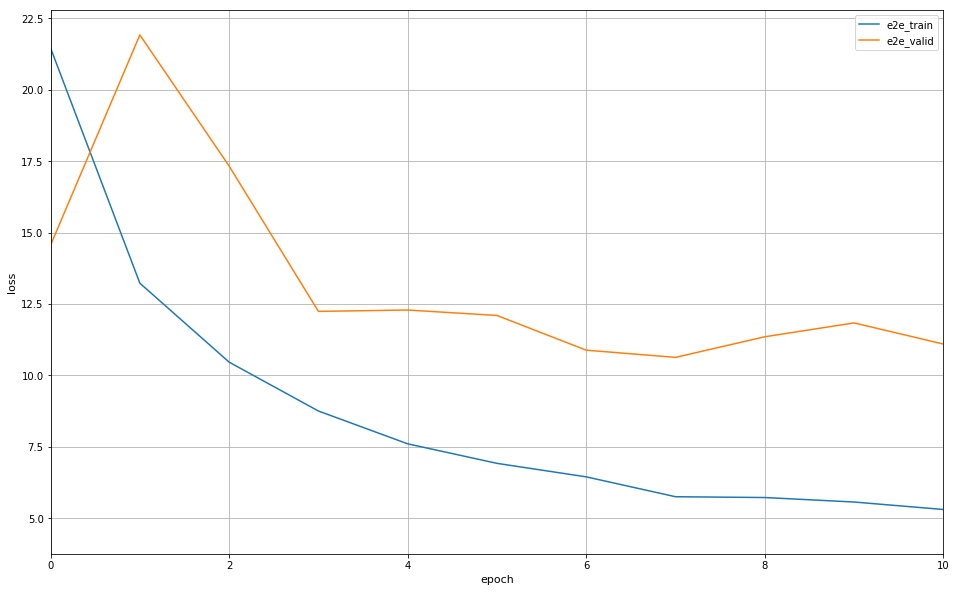

In [33]:
# list all data in history
print(ki_history.history.keys())
# summarize history for loss
plt.plot(ki_history.history['loss'])
plt.plot(ki_history.history['val_loss'])

# plt.title('model loss')
plt.ylabel('loss', fontsize=11)
plt.xlabel('epoch', fontsize=11)
plt.legend(['e2e_train', 'e2e_valid'], loc='best')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 2))
plt.grid()
plt.show()

In [35]:
#save model
ki_model.save('.\\inbox\\ki_model.h5')



AttributeError: 'History' object has no attribute 'save'

# 4 Compare

## 4.1 Loss “MSE” —— Train & Valid 

NameError: name 'maxpool_history' is not defined

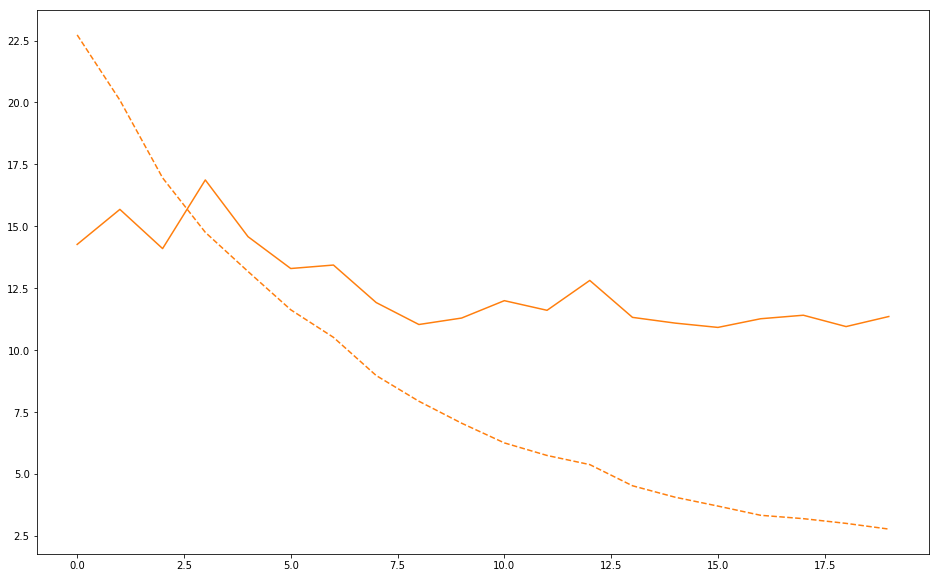

In [30]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,10)




# plt.plot(raw_vgg_history.history['loss'][1:], 'C0--')
# plt.plot(raw_vgg_history.history['val_loss'][1:], 'C0')

plt.plot(raw_nvidia_history.history['loss'], 'C1--')
plt.plot(raw_nvidia_history.history['val_loss'], 'C1')

plt.plot(maxpool_history.history['loss'], 'C2--')
plt.plot(maxpool_history.history['val_loss'], 'C2')

plt.plot(dropout_history.history['loss'], 'C3--')
plt.plot(dropout_history.history['val_loss'], 'C3')

plt.plot(elu_history.history['loss'][:20], 'C4--')
plt.plot(elu_history.history['val_loss'][:20], 'C4')

plt.plot(bn_history.history['loss'][:20], 'C5--')
plt.plot(bn_history.history['val_loss'][:20], 'C5')

plt.plot(ki_history.history['loss'][:20], 'C6--')
plt.plot(ki_history.history['val_loss'][:20], 'C6')

plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim((0,20))
plt.xticks(np.arange(0, 21, 2))

plt.legend(['train VGG16', 'valid VGG16', 
            'train raw_e2e', 'valid raw_e2e', 
            'train e2e+MaxPool', 'valid e2e+MaxPool',
            'train e2e+MaxPool+Dropout', 'valid e2e+MaxPool+Dropout', 
            'train e2e+MaxPool+Dropout+ELU', 'valid e2e+MaxPool+Dropout+ELU',
            'train e2e+MaxPool+Dropout+ELU+ki', 'valid e2e+MaxPool+Dropout+ELU+ki'], 
           loc='upper right')

plt.show()

## 4.2 Loss “MSE” —— Test

| Model | Train Loss | Valid Loss |Test Loss |
| ------ | ------ | ------ |------ |
| VGG16+Transfer Learning | 22.8434  | 14.3261 | 7.865|
| Raw End to End | 2.753 | 12.982 |5.228|
| e2e+Maxpool | 0.568 | 8.834 |3.667|
| e2e+Maxpool+Dropout | 7.390 | 8.834 |5.226|
| e2e+Maxpool+Dropout+ELU | 3.594 | 10.874 |4.353|
| e2e+Maxpool+Dropout+ELU+BN | 4.1537 | 10.280 |2.927|
| e2e+Maxpool+Dropout+ELU+BN+ki | 5.3342 | 9.740 |3.057|

# 5 Predict Steering

In [47]:
machine_steering = ki_model.predict(imgs_test, batch_size=128, verbose=0)

In [48]:
def get_tesla_steering(epoch_id):
    epoch_dir = params.data_dir
    assert os.path.isdir(epoch_dir)
    steering_path = os.path.join(epoch_dir, 'epoch{:0>2}_steering.csv'.format(epoch_id))
    assert os.path.isfile(steering_path)
    
    rows = pd.read_csv(steering_path)
    tesla_steering = list(rows.wheel.values)
    return tesla_steering

In [49]:
test_tesla_steering = get_tesla_steering(10)

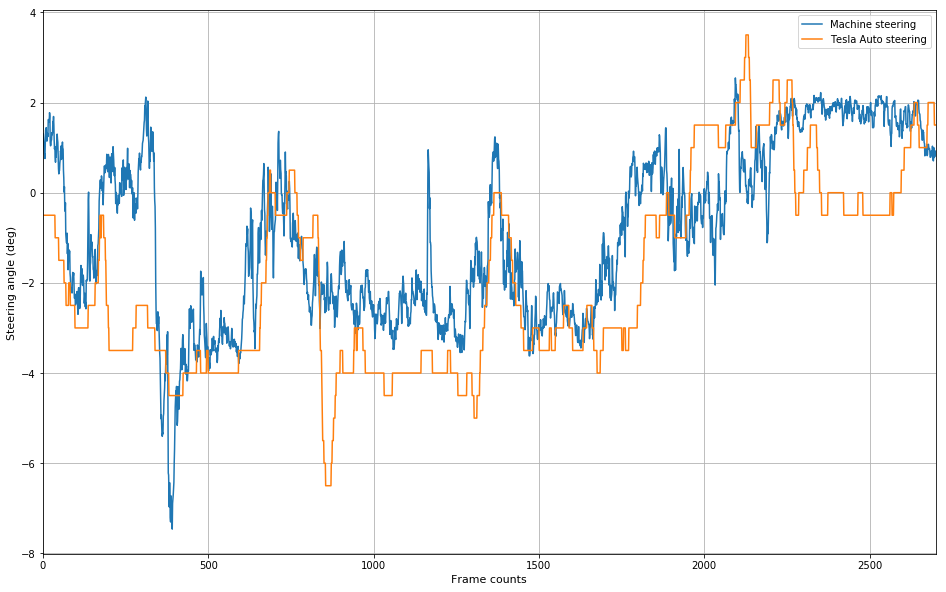

In [50]:
plt.figure
plt.plot(machine_steering)
plt.plot(test_tesla_steering)
plt.ylabel('Steering angle (deg)', fontsize=11)
plt.xlabel('Frame counts', fontsize=11)
plt.legend(['Machine steering', 'Tesla Auto steering'], loc='upper right')
plt.xlim((0,2700))

plt.grid()

plt.show()

# 6 Analysis 

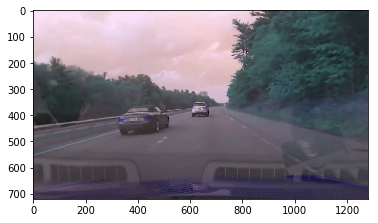

In [31]:

video_path = ".\epochs\epoch10_front.mkv"

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES,2150)  #设置要获取的帧号
ret, img = cap.read()
cap.release()
## Show

plt.imshow(img)
# pylab.show() 

TypeError: Image data cannot be converted to float

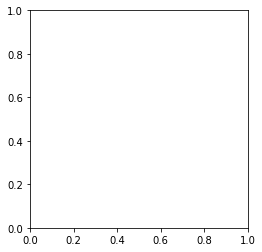

In [24]:

video_path = ".\epochs\epoch10_front.mkv"
cap2 = cv2.VideoCapture(video_path)
cap2.set(cv2.CAP_PROP_POS_FRAMES,2500)  #设置要获取的帧号
ret, img2 = cap.read()
cap2.release()
## Show

plt.imshow(img2)
# pylab.show() 